# Merge testis all replicates

In [23]:
options(repr.plot.width=10, repr.plot.height=10)
source('../lib/seurat.R')
library(Seurat)
library(dplyr)
library(Matrix)

In [2]:
OUTDIR <- '../output/combined_testis_force'
REFERENCES_DIR <- Sys.getenv('REFERENCES_DIR')

# Get list of mitochondiral genes
fbgn2chrom <- read.table('../output/fbgn2chrom.tsv', header=T)
fbgn2symbol <- read.csv(file.path(REFERENCES_DIR, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'), header=T, sep = '\t')[, c('gene_symbol', 'primary_FBgn')]
mito <- fbgn2chrom[fbgn2chrom$chrom == 'chrM', 'FBgn']

In [2]:
# Load the 10x dataset Rep 1
tenX.data <- Read10X(data.dir = '../output/testis1_force/outs/filtered_gene_bc_matrices/dm6.16')
r1 <- CreateSeuratObject(raw.data = tenX.data, min.cells = 3, min.genes = 200, project = 'GroupCluster')
r1@meta.data$rep <- 'rep1'
r1 <- FilterCells(object = r1, subset.names = c("nGene"), low.thresholds = c(200), high.thresholds = c(6000))
r1 <- NormalizeData(object = r1, normalization.method = "LogNormalize", scale.factor = 1e4)
r1 <- ScaleData(object = r1, vars.to.regress = c("nUMI"), display.progress = FALSE)

In [3]:
# Load the 10x dataset Rep 2
tenX.data <- Read10X(data.dir = '../output/testis2_force/outs/filtered_gene_bc_matrices/dm6.16')
r2 <- CreateSeuratObject(raw.data = tenX.data, min.cells = 3, min.genes = 200, project = 'GroupCluster')
r2@meta.data$rep <- 'rep2'
r2 <- FilterCells(object = r2, subset.names = c("nGene"), low.thresholds = c(200), high.thresholds = c(6000))
r2 <- NormalizeData(object = r2, normalization.method = "LogNormalize", scale.factor = 1e4)
r2 <- ScaleData(object = r2, vars.to.regress = c("nUMI"), display.progress = FALSE)

In [4]:
# Load the 10x dataset Rep 3
tenX.data <- Read10X(data.dir = '../output/testis2_force/outs/filtered_gene_bc_matrices/dm6.16')
r3 <- CreateSeuratObject(raw.data = tenX.data, min.cells = 3, min.genes = 200, project = 'GroupCluster')
r3@meta.data$rep <- 'rep3'
r3 <- FilterCells(object = r3, subset.names = c("nGene"), low.thresholds = c(200), high.thresholds = c(6000))
r3 <- NormalizeData(object = r3, normalization.method = "LogNormalize", scale.factor = 1e4)
r3 <- ScaleData(object = r3, vars.to.regress = c("nUMI"), display.progress = FALSE)

In [5]:
# Find the highly variable genes
r1 <- FindVariableGenes(
    object = r1, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    do.plot = FALSE, 
    x.low.cutoff = 0.01, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5, 
    y.high.cutoff = Inf
)

r2 <- FindVariableGenes(
    object = r2, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    do.plot = FALSE, 
    x.low.cutoff = 0.01, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5, 
    y.high.cutoff = Inf
)

r3 <- FindVariableGenes(
    object = r3, 
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    do.plot = FALSE, 
    x.low.cutoff = 0.01, 
    x.high.cutoff = 3, 
    y.cutoff = 0.5, 
    y.high.cutoff = Inf
)

In [6]:
# Create list of genes to use
g.1 <- r1@var.genes
g.2 <- r2@var.genes
g.3 <- r3@var.genes
genes.use <- intersect(intersect(g.1, g.2), g.3)

In [7]:
# Rename cells incase they overlap between replicates
r1@cell.names <- paste('rep1', r1@cell.names, sep='_')
r2@cell.names <- paste('rep2', r2@cell.names, sep='_')
r3@cell.names <- paste('rep3', r3@cell.names, sep='_')

colnames(r1@raw.data) <- paste('rep1', colnames(r1@raw.data), sep = "_")
colnames(r2@raw.data) <- paste('rep2', colnames(r2@raw.data), sep = "_")
colnames(r3@raw.data) <- paste('rep3', colnames(r3@raw.data), sep = "_")

rownames(r1@meta.data) <- paste('rep1', rownames(r1@meta.data), sep = "_")
rownames(r2@meta.data) <- paste('rep2', rownames(r2@meta.data), sep = "_")
rownames(r3@meta.data) <- paste('rep3', rownames(r3@meta.data), sep = "_")

In [8]:
combined <- RunMultiCCA(
    list(r1, r2, r3), 
    genes.use=genes.use, 
    num.cc=10, 
)

[1] "Computing CC 1"
[1] "Computing CC 2"
[1] "Computing CC 3"
[1] "Computing CC 4"
[1] "Computing CC 5"
[1] "Computing CC 6"
[1] "Computing CC 7"
[1] "Computing CC 8"
[1] "Computing CC 9"
[1] "Computing CC 10"
[1] "Scaling data matrix"
  |======================================================================| 100%


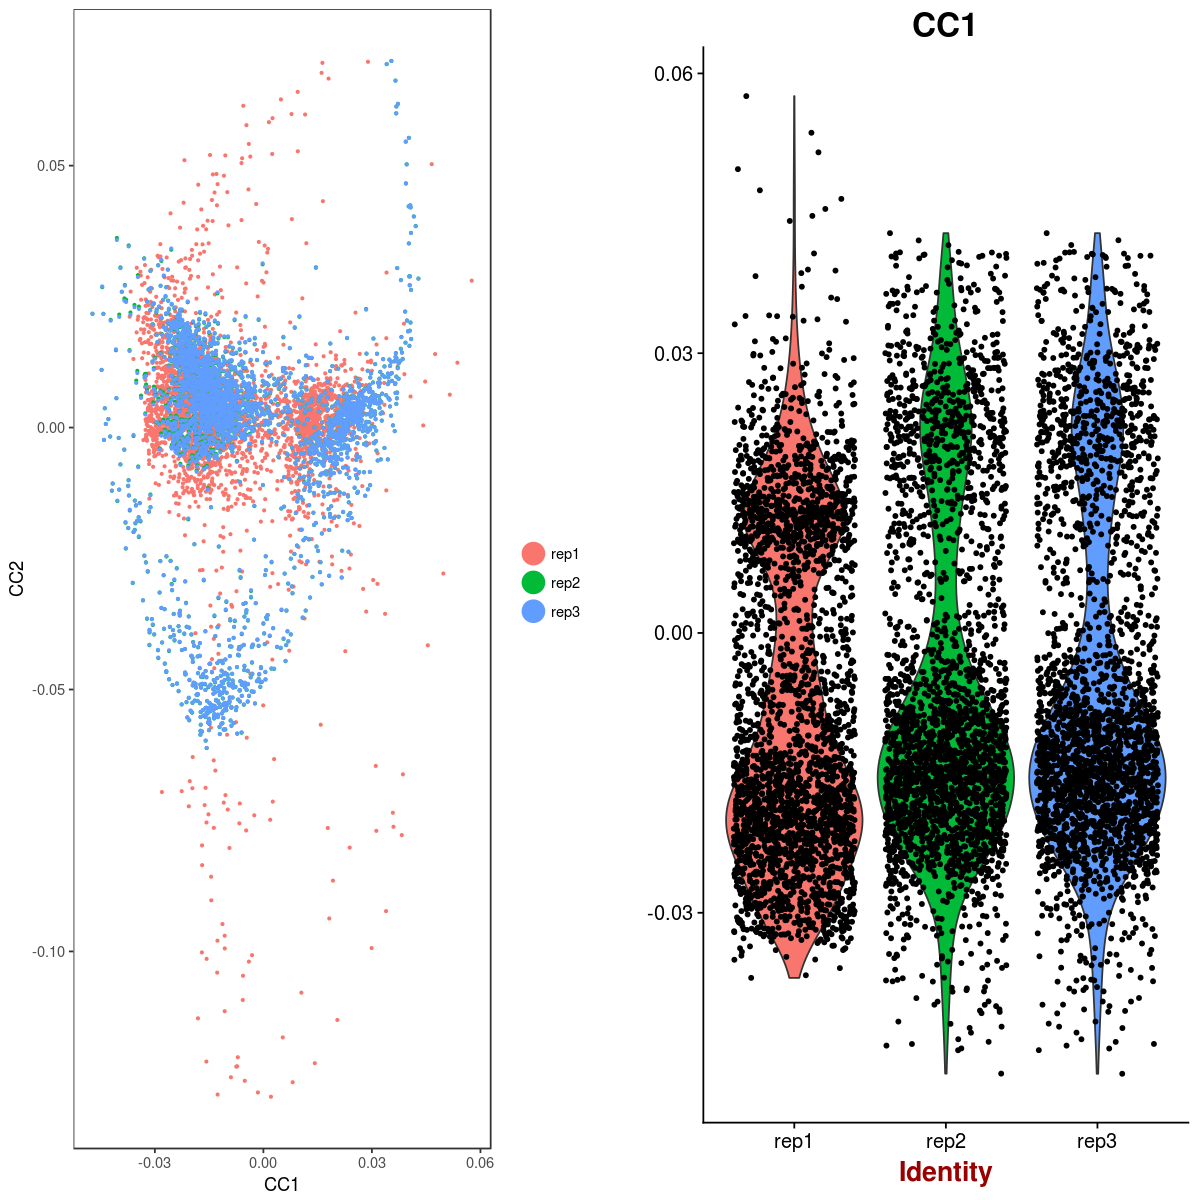

In [9]:
p1 <- DimPlot(object=combined, reduction.use='cca', group.by='rep', pt.size=0.5, do.return=TRUE)
p2 <- VlnPlot(object=combined, features.plot='CC1', group.by='rep', do.return=TRUE)
plot_grid(p1, p2)

In [10]:
combined <- AlignSubspace(combined, reduction.type = "cca", grouping.var = "rep", dims.align = 1:10)

[1] "Scaling data matrix"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


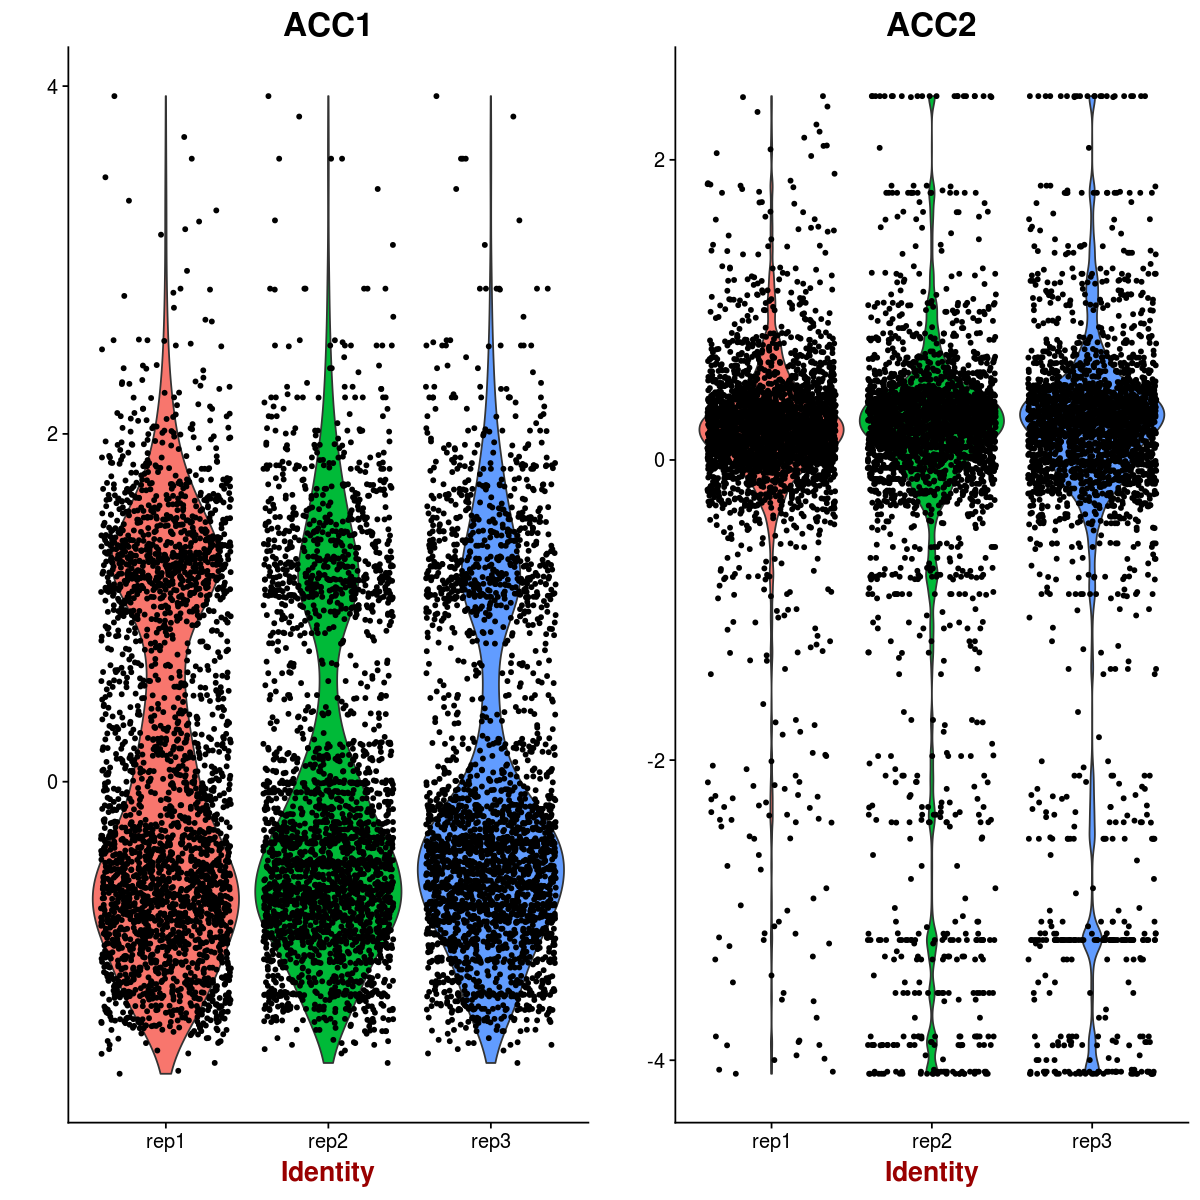

In [11]:
p1 <- VlnPlot(object=combined, features.plot='ACC1', group.by='rep', do.return=TRUE)
p2 <- VlnPlot(object=combined, features.plot='ACC2', group.by='rep', do.return=TRUE)
plot_grid(p1, p2)

In [12]:
combined <- RunTSNE(combined, reduction.use = "cca.aligned", dims.use = 1:10, do.fast = T)
combined <- FindClusters(combined, reduction.type = "cca.aligned", resolution = c(0.4, 0.6, 1.0, 1.2, 1.4), dims.use = 1:10)

[1] "Constructing SNN"
  |======================================================================| 100%


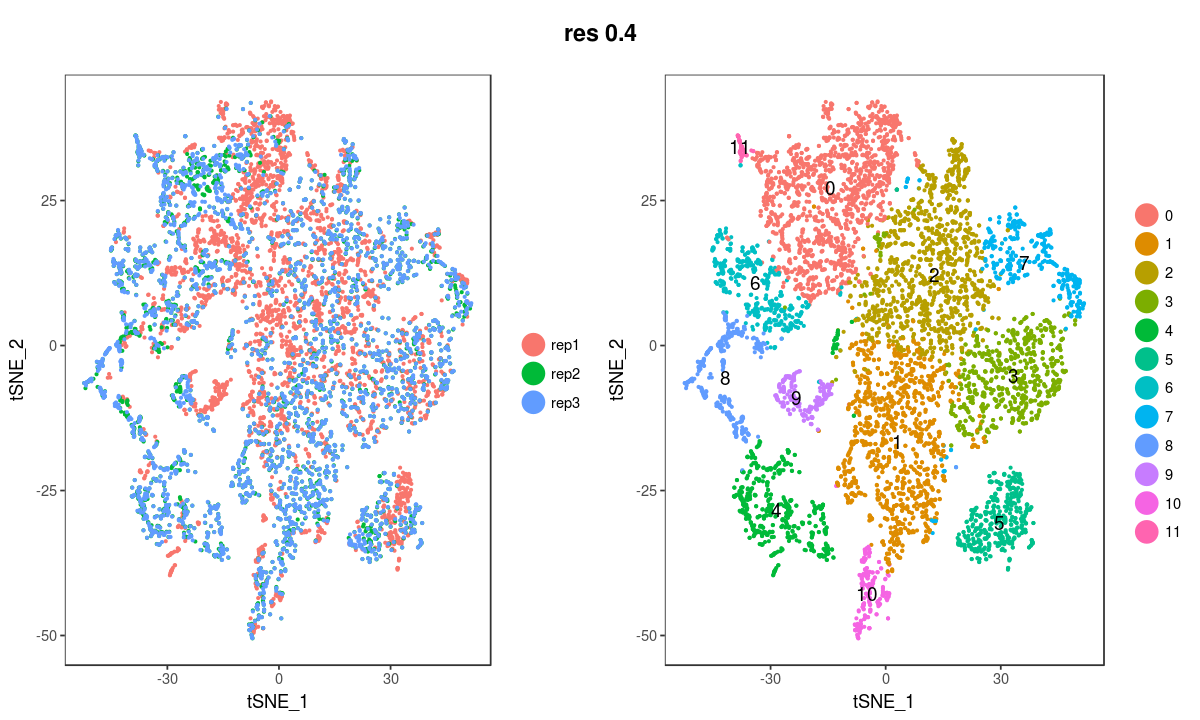

In [30]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.0.4')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 0.4", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

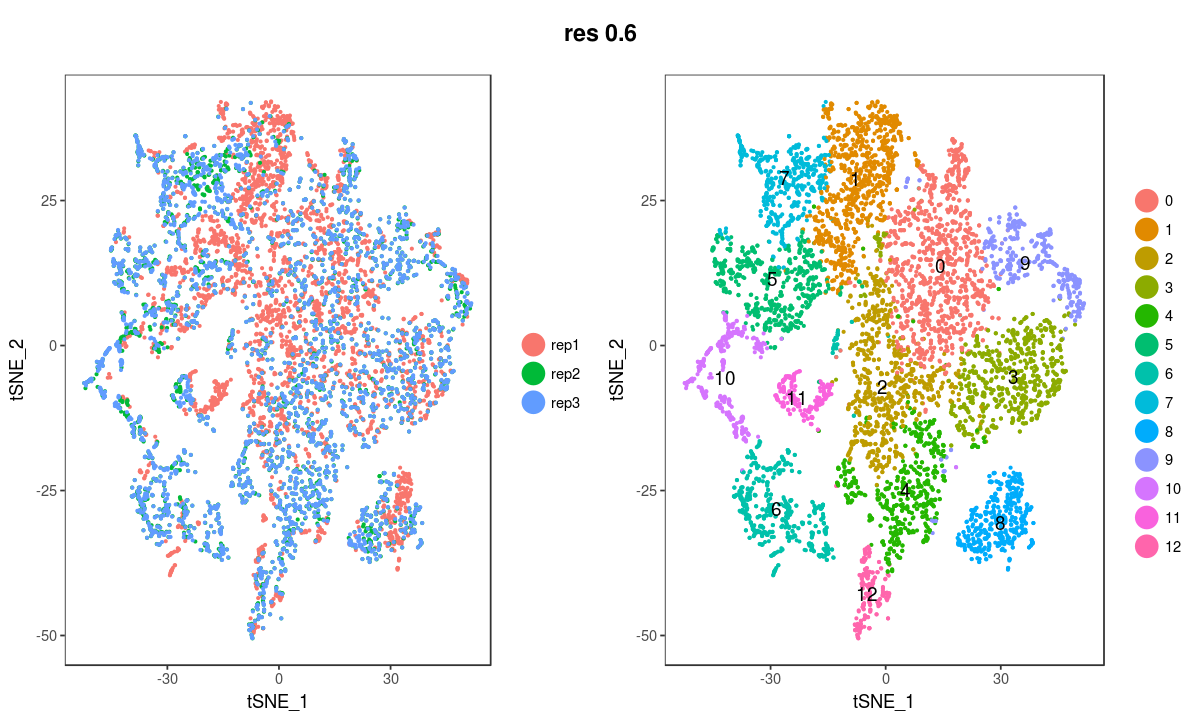

In [31]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.0.6')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 0.6", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

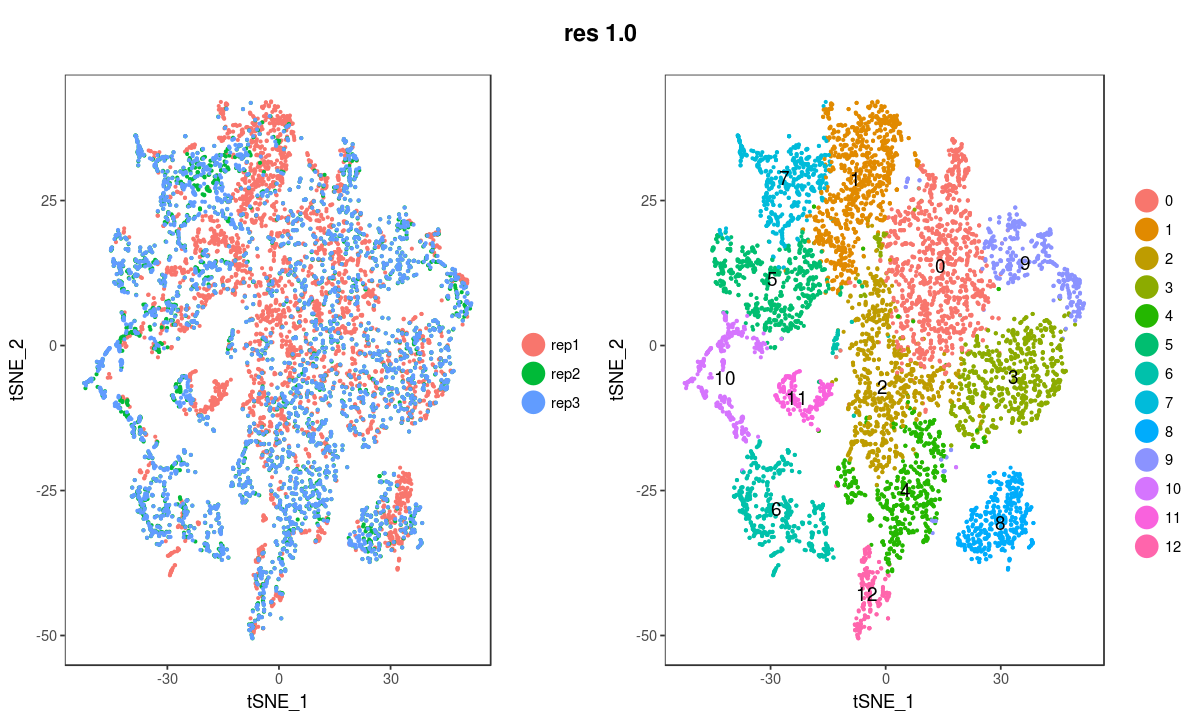

In [32]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.1.0')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 1.0", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

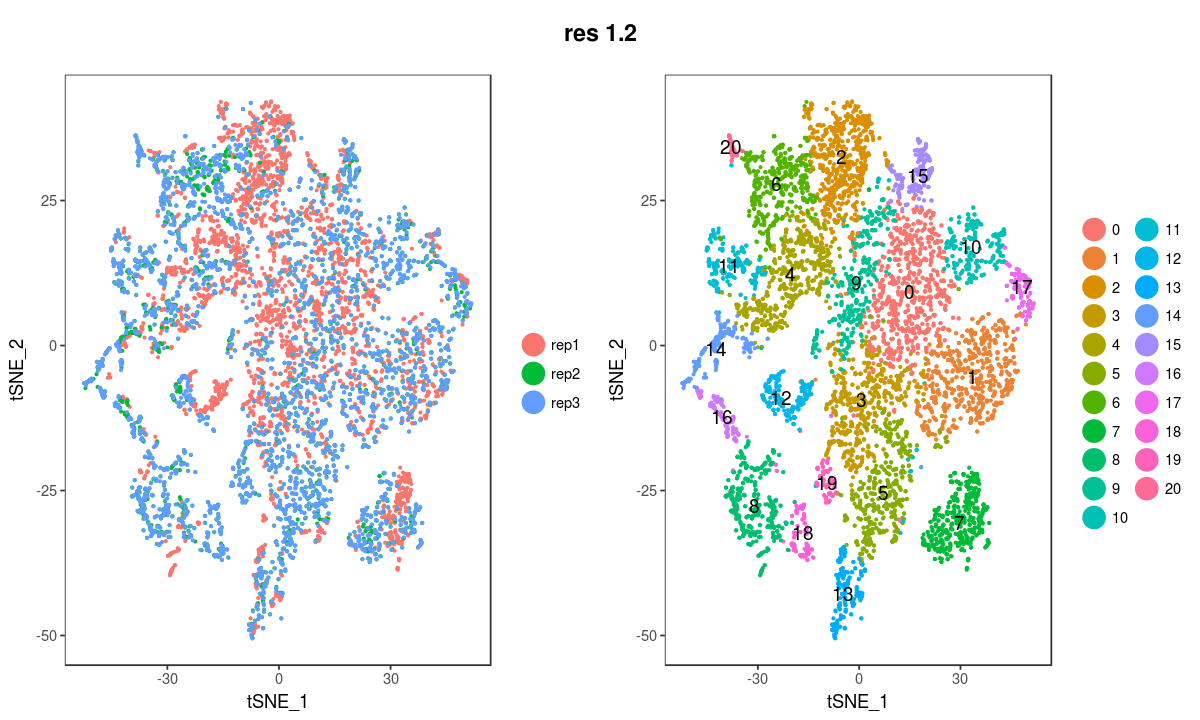

In [33]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.1.2')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 1.2", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

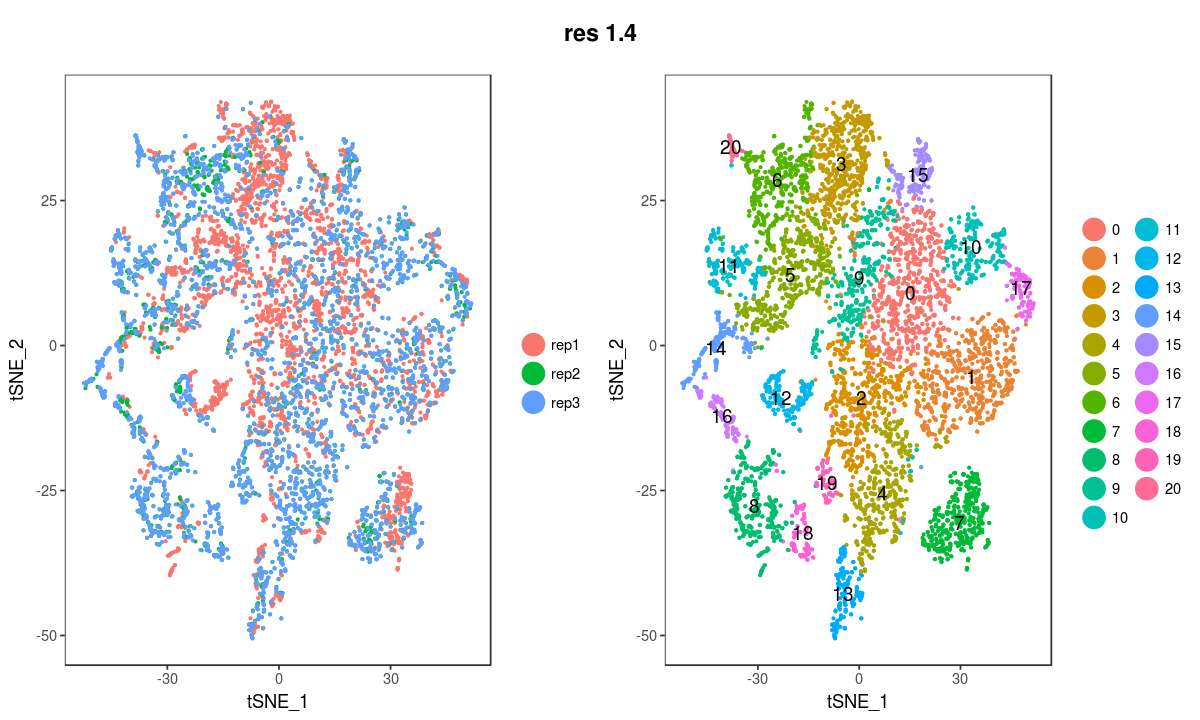

In [34]:
options(repr.plot.width=10, repr.plot.height=6)
combined <- SetAllIdent(combined, id  = 'res.1.4')
p1 <- TSNEPlot(combined, do.return = T, pt.size = 0.5, group.by = "rep")
p2 <- TSNEPlot(combined, do.label = T, do.return = T, pt.size = 0.5)
p <- plot_grid(p1, p2)
title <- ggdraw() + draw_label("res 1.4", fontface='bold')
plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) # rel_heights values control title margins

In [3]:
load(file.path(OUTDIR, 'seurat.Robj'))
combined <- object

In [24]:
dump_seurat(object = combined, dir = OUTDIR)

In [ ]:
# Save cluster info
params <- c(0.4, 0.6, 1.0, 1.2, 1.4)
params <- c(1.0, 1.2, 1.4)
for (i in params) {
    name <- paste0('res.', i)
    fname <- paste0('biomarkers_', i, '.tsv')
    combined <- SetAllIdent(combined, id = name)
    markers <- FindAllMarkers(object = combined, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25, print.bar = FALSE)
    markers = merge(fbgn2symbol, markers, by.x='primary_FBgn', by.y='gene', all.y=T)
    save_biomarkers(markers = markers, dir = OUTDIR, fname = fname)
}